# TP 2: Approximate Inference

**Recap:** In bayesian models, we model the prior $p(w)$ and the likelihood  $p(Y \vert X,w)$, and we aim at estimating: 
- The posterior $p(w | D)$ 
- The predictive distribution by marginalyzing over w with the posterior: $p(y^* | x^* ,D) = \int p(y^* |x^* ,w)p(w | D) dw$

In the first session, we saw that both $p(w | D)$  and $p(y^* | x^* ,D)$ have clodes-form solution for Bayesian Linear Regression. 

During this session, we will first study the Bayesian Logistic Regression (BLR), for which closed-form solution for the posterior already do not exist. We explore Laplace approximation, and compare the predictive distribution result comparer to a point-wise Maximum A Posteriori (MAP) estimate. 

Then, we will explore MC dropout as variational approximation for non-linear regression and classification tasks.

**Goal**: Take hand on approximate inference methods and understand how it works

**Requirements**: 
- Pytorch library:
`pip install torch torchvision`

NB: if you don't have root access on the computer, add `--user` to install the library locally.

## Part I: Bayesian Logistic Regression

In previous linear regression, our model prediction is of the continuous form $f(x)=wTx+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $x$. 
Let's consider here binary classification:
$$f(x) = \sigma(w^T x + b)$$
where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior: 
$$ p(w) = \mathcal{N}(w \vert \mu_0, \Sigma_0) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

In [5]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from IPython import display

In [6]:
# Toy dataset
X, y = make_blobs(n_samples=400, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X = torch.from_numpy(X)
y = torch.from_numpy(y.astype(float))
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

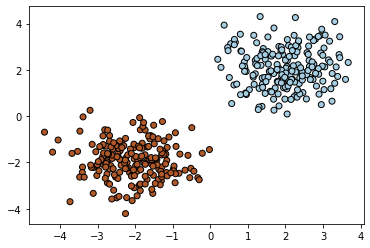

In [7]:
# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')

In [8]:
# Useful function: plot and show learning process in classification
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic', samples=100, nbh=2, cmap='RdBu', posterior=0):    
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))
    
    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()])
    test_tensor = test_tensor.type(torch.FloatTensor)
    if model_type=='classic':
        model.eval()
        pred = model(test_tensor)
    elif model_type=='laplace-sampling':
        model.eval()
        model.training = True
        outputs = torch.zeros(nS, test_tensor.shape[0], 1)
        for i in range(nS):
            state_dict['fc1.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
            model.load_state_dict(state_dict)
            outputs[i] = net(test_tensor)
        pred = outputs.mean(0).squeeze()

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(-4, -7, f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})

## II.1 First solution: MAP estimate

Here, we reduce our posterior distribution $p(w | D)$ to a point estimate $w_{MAP}$ in order to be able to approximate the predictive distribution as:
$$ p(y^* = 1|x^*,D) = \int p(y^* =1 |x^*,w)p(w | D)dw \approx p(y^* =1 |x^*,w_{MAP}) $$
This approximation is called the **plug-in approximation**.

The point estimate corresponds to the Maximum A Posteriori given by:
$$ w_{MAP} = arg \max_w p(w \vert Y,X) = arg \max_w p(Y \vert X,w)p(w) $$
In case of a Gaussian prior, we further obtain:
$$ w_{MAP} = arg \min_w \sum_{n=1}^N \big ( -y_n \log \sigma(w^T x_n + b) - (1-y_n) \log (1 - \sigma(w^T x_n + b)) + \frac{1}{2 \Sigma_0^2} \vert \vert w \vert \vert_2^2 \big ) $$

Note that:
- We recover our usual **cross-entropy** in classification with a weight decay regularization
- Unlike in linear regression $w_{MAP}$ **cannot be computed analytically**
- Optimization methods can however be used to compute it, e.g. **stochastic gradient descent**
- The main disadvantage is we cannot obtain a distribution over w


As a consequence, **the objective is simply to implement and train a Logistic Regression model** with Pytorch and then compute $p(y^* = 1|x^*,D)$ as in a deterministic model.

**Question 1.1: Code Logistic Regression model class in Pytorch below**

In [ ]:
#TO DO: Code Logistic Regression in Pytorch

class LogisticRegression(nn.Module):
    """ A D-dimension Logistic Regression Model in Pytorch"""
    def __init__(self, D):
        super().__init__()
        # To Do

    def forward(self, x):
        # To Do
        return 0

In [7]:
net = LogisticRegression(D=2)
net.train()
wd = 5e-1
optimizer = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=wd

NameError: name 'LogisticRegression' is not defined

In [6]:
# Use the following code for the loss, which will be required for Laplace approximation (II.2) 
def binary_cross_entropy(x, y):
    loss = -(x.log() * y + (1 - x).log() * (1 - y))
    return loss.mean()


**Question 1.2:  Train Logistic Regression with gradient descent for 20 epochs in code below**

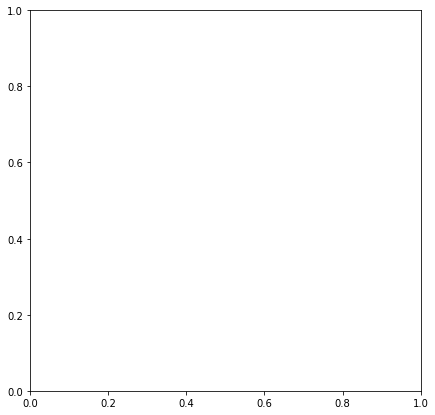

In [9]:
#TO DO: Train Logistic Regression with gradient descent for 20 epochs

fig, ax = plt.subplots(figsize=(7,7))

# To DO here

# For plotting and showing learning process at each epoch, uncomment and indent line below
#plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), model_type='classic')

**Question 1.3: Analyze the results showed on plot. Looking at $p(y=1 | x, w_{MAP})$, what can you say about points far from train distribution?**

## II.2 Laplace Approximation

We will use Laplace approximation to estimate the intractable posterior $p(\boldsymbol{w} | D)$.

With the Laplace approximation , $p(\boldsymbol{w} | D)$ is approximated with a normal distribution: $p(\boldsymbol{w} | D) \approx q(\boldsymbol{w}) = \mathcal{N}(\boldsymbol{w} ; \boldsymbol{\mu}, \boldsymbol{\Sigma})$, where: 

- The mean of the normal distrubution $\boldsymbol{\mu}$ corresponds to the mode of $p(\boldsymbol{w} | D)$. It simply consists in taking the solution of MAP, *i.e.* $\boldsymbol{\mu} = w_{MAP} = \arg \underset{\boldsymbol{w}} \min    -log\left[ p(\boldsymbol{w} | D)\right]$. 
- The covariane matrix is obtained by the Hessain of the loss function $-log\left[ p(\boldsymbol{w} | D)\right]$ at $w=w_{MAP}$: $\boldsymbol{\Sigma}^{-1} = \nabla \nabla_{\boldsymbol{w}} p(\boldsymbol{w} \vert D) |_{\boldsymbol{w} = \boldsymbol{w}_{MAP}}$


**Question 1.4: extract w_map after training the logistic regression model**. This is simply current the weights of the model. 

In [ ]:
# TO DO 
w_map = 

**To compute the Hessian, with first compute the gradient at w_map**:

In [3]:
from torch.autograd import grad
optimizer.zero_grad()
output = net(X).squeeze()
loss = binary_cross_entropy(output, y) + wd*net.fc1.weight.norm()**2
gradf_val, = grad(loss, net.fc1.weight, create_graph=True)

NameError: name 'binary_cross_entropy' is not defined

**Question 1.5: apply the same grad function on each scalar element of the gradient to get each raw of the Hessian**. Concatenate both, detach and convert into numpy. **Compute the covariance by inverting th Hessian** 

In [ ]:
Sigma_laplace = 

**From mean and covariance, we can sample the posterior**: 

In [ ]:
nS = 100
laplace_posterior =  np.random.multivariate_normal(w_map.numpy().reshape(2,), Sigma_laplace , nS)

**Once the approximate posterior $q(\boldsymbol{w})$ is computed, we use MC sampling to compute the predictive distribution (plot_decision_boundary function)**: 
- Load new state dict into model to sample a weight vector 
- Run forward pass to get an output

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), model_type='laplace-sampling', posterior=laplace_posterior)

# Part II: MC Dropout variational inference 


We can leverage the results shown in [[1]](https://arxiv.org/abs/1506.02142) to efficiently estimate approximate predictive distribution with a neural network trained with dropout.
In pratice, this simply consists in activating the dropout sampling during test, which is leveraged for computing the predictive distribution. We can extract statistics (eg mean and variance) for characterizing the predictive distribution. 


## II.1: MC Dropout for regression 
We expand last week's analysis on non-linear models for Bayesian regression. Here, we will define and use a Bayesian Neural Network with MCDropout variational inference to estimate uncertainty on a sinusoidal toy dataset.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from IPython import display

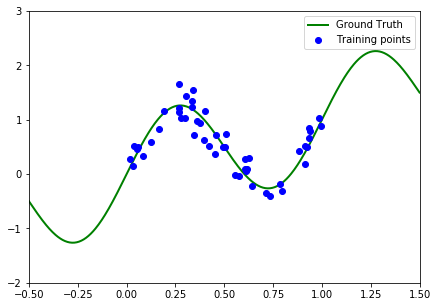

In [11]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount, sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

sigma = 0.1
nbpoints = 50

# Create training and test points
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpoints)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1)
dataset_sinus['X_test'] = np.linspace(-0.5,1.5, 10*nbpoints)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0)

# Hyperparameters
dataset_sinus['ALPHA'] = 0.01
dataset_sinus['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-0.5, xmax = 1.5)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [12]:
X_train_tensor = torch.from_numpy(dataset_sinus['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset_sinus['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset_sinus['X_test'].copy()).float().unsqueeze(dim=1)

In [13]:
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range
    
    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot
      
    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="MC dropout")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])
    
    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")   
    
    plt.legend()
    plt.show()

In [14]:
# Useful function: plot and show learning process in regression
def plot_learning_process(X_train_tensor, y_train_tensor, outputs, loss, epoch):
    """Given 1D training input and prediction vector, this function output a plot of 
    the predicted function and value of the loss, both updated at each epoch.

    Args:
      X_train_tensor: (tensor) train inputs, sized [N,1]
      y_train_tensor: (tensor) train labels, sized [N, ]
      output: (tensor) prediction vector from NN, sized [N, ]
      loss: (float) current loss value
      epoch: (int) current epoch
      
    Returns:
      None
    """
    plt.cla()
    ax.set_title('Regression Analysis')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-2, 3)
    ax.scatter(X_train_tensor.data.numpy(), y_train_tensor.data.numpy(), color = "orange")
    ax.plot(X_train_tensor.sort(0).values.data.numpy(), output[X_train_tensor.sort(0).indices].data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.3, 'Step = %d' % epoch, fontdict={'size': 20, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss, fontdict={'size': 20, 'color':  'red'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

**Question 2.1: Code a Multi-Layer Perceptron, a neural network with one hidden layer, and add a Dropout Layer with p=0.25.**

In [15]:
#TO DO: Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout layer should be also activated 
#during test time.
#(Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP model with an added dropout layer"""
    def __init__(self, hidden_size):
        super().__init__()
        # To DO

    def forward(self, x):
        # To DO
        return 0

In [16]:
net = MLP(hidden_size=100)
net.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)

ValueError: optimizer got an empty parameter list

**Question 2.2: Train the model for 5000 epoch, batch size equals to training set. Use ``plot_learning_process()`` to visualize training.**

Finished Training


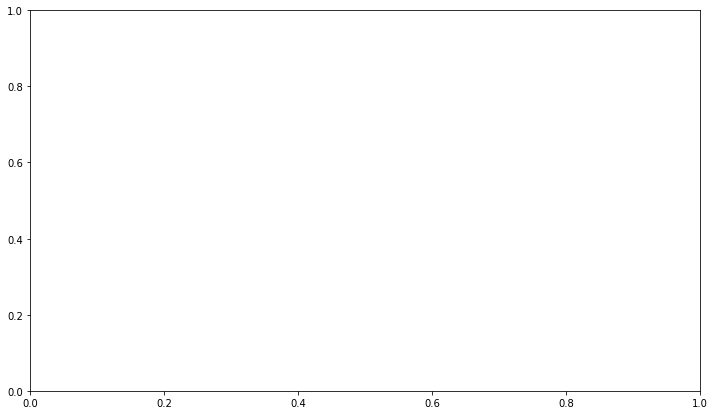

In [28]:
#TO DO: Train MLP for 5000 epochs

fig, ax = plt.subplots(figsize=(12,7))

# To DO here


# For plotting and showing learning process at each epoch, uncomment and indent line below
#if (epoch+1)%100==0:
#    plot_learning_process(X_train_tensor, y_train_tensor, output, loss.data.numpy(), epoch+1)

print('Finished Training')

**Question 2.3: Predict on test set using MC sampling s=1000 (or 10000) samples and visualize results. What can you say about the predictive variance?**

In [29]:
#TO DO: Predict on test set and visualize results using plot_results

net.eval()
net.training = True

# To DO here


# For plotting using, uncomment the following function (need to have compute y_pred and std_pred)
#plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'],
#             y_pred, std_pred, xmin=-0.5, xmax=1.5, ymin=-2, ymax=3, stdmin=0, stdmax=0.3)

## II.2 MC Dropout for non-linear classification

**We tackle the problem of learning a deep neural network for performing classification in the non-linear "moons" dataset**

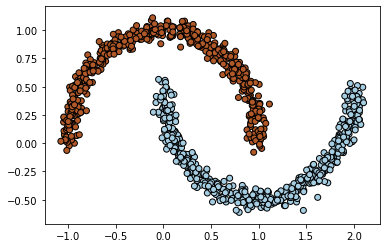

In [30]:
import matplotlib.pyplot as plt
from sklearn import datasets
no = 0.05
#no = 0.0
X, y = datasets.make_moons(n_samples=1000, noise=no)
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')

Convert data into torch tensors:

In [31]:
X = torch.from_numpy(X)
X = X.type(torch.FloatTensor)
y = torch.from_numpy(y.astype(float))
y = y.type(torch.FloatTensor)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

**Question 2.4: Implement MLP with dropout model by completing code below** : 
- 2 hidden layers of size nH
- Apply leaky relu activation (with negative slope 0.1) after each hidden layer 
- Apply dropout after leaky relu (prob 0.5 and 0.2)
- The last linear projection output a single neuron with sigmoid activation for classification

In [32]:
#TO DO: Code MLP with 2 hidden layers and dropout at each hidden layer. Be careful, the dropout layer should be also activated 
#during test time.
#(Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, nH=200):
        super().__init__()
        
    def forward(self, x):
        return 0

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

net = MLP(nH=200)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)  

ValueError: optimizer got an empty parameter list

In [34]:
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic', samples=100, nbh=2, cmap='RdBu'):    
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 15*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 15*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*1.5, x_max*1.5, h),
                         np.arange(y_min*1.5, y_max*1.5, h))
    
   
    
    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()])
    test_tensor = test_tensor.type(torch.FloatTensor)
    
    if model_type=='classic':
        model.eval()
        pred = model(test_tensor)
        #pred[pred>0.5] = 1
        #pred[pred<0.5] = 0
    elif model_type=='mcdropout':
        model.eval()
        model.training = True
        outputs = torch.zeros(samples, test_tensor.shape[0], 1)
        for i in range(samples):
            outputs[i] = model(test_tensor)
        pred = outputs.mean(0).squeeze()
        print("stds=",outputs.std(0).squeeze())
    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(-2, -1.5, f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

**Question 2.7:  Train MLP with gradient descent for 200 epochs in code below**

Finished Training


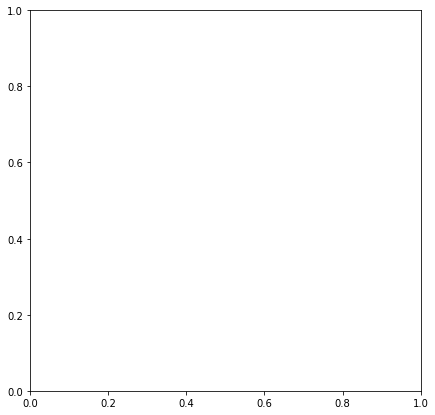

In [35]:
#TO DO: Train MLP for 200 epochs

fig, ax = plt.subplots(figsize=(7,7))

# To Do here


# For plotting and showing learning process at each epoch, uncomment line below
#if(epoch%5==0):
    #plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean())
print('Finished Training')

**Visualize predicive uncertainty when applying MC dropout sampling on test set**

NameError: name 'epoch' is not defined

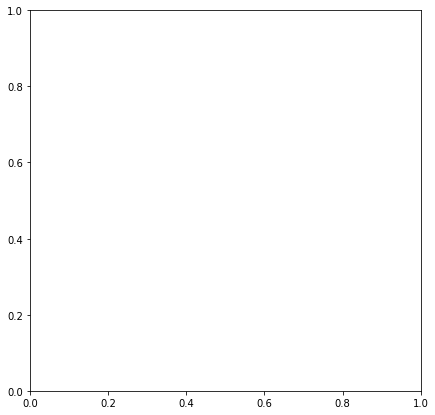

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), model_type='mcdropout')